In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
#from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy('mixed_bfloat16')


print(tf.__version__)

2.13.0


In [2]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, History
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 43  # Number of classes for traffic signs
EPOCHS_TOP_LAYERS = 10
EPOCHS_FINE_TUNING = 15

train_dir = "F:\DATASET\TRAFFIC SIGNS PICKLE DATA 0 224x224/train"
valid_dir = "F:\DATASET\TRAFFIC SIGNS PICKLE DATA 0 224x224/valid"
test_dir = "F:\DATASET\TRAFFIC SIGNS PICKLE DATA 0 224x224/test"

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

#freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# custom layers
x = layers.Dense(256)(base_model.output)
x = layers.Activation(activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(NUM_CLASSES)(x)
predictions = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Found 86989 images belonging to 43 classes.
Found 4410 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                              

In [4]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    epochs=10,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/10
1360/1360 [==============================] - 1408s 1s/step - loss: 1.2148 - accuracy: 0.6565 - val_loss: 0.9512 - val_accuracy: 0.7129 - lr: 5.0000e-04
Epoch 2/10
1360/1360 [==============================] - 1394s 1s/step - loss: 0.6891 - accuracy: 0.8025 - val_loss: 0.9146 - val_accuracy: 0.7079 - lr: 5.0000e-04
Epoch 3/10
1360/1360 [==============================] - 1307s 961ms/step - loss: 0.5823 - accuracy: 0.8299 - val_loss: 0.9890 - val_accuracy: 0.7188 - lr: 5.0000e-04
Epoch 4/10
1360/1360 [==============================] - 1354s 996ms/step - loss: 0.5278 - accuracy: 0.8446 - val_loss: 0.9026 - val_accuracy: 0.7358 - lr: 5.0000e-04
Epoch 5/10
1360/1360 [==============================] - 1365s 1s/step - loss: 0.4963 - accuracy: 0.8512 - val_loss: 1.0370 - val_accuracy: 0.7152 - lr: 5.0000e-04
Epoch 6/10
1360/1360 [==============================] - 1333s 980ms/step - loss: 0.4753 - accuracy: 0.8578 - val_loss: 1.0252 - val_accuracy: 0.6971 - lr: 5.0000e-04
Epoch 7/10
13

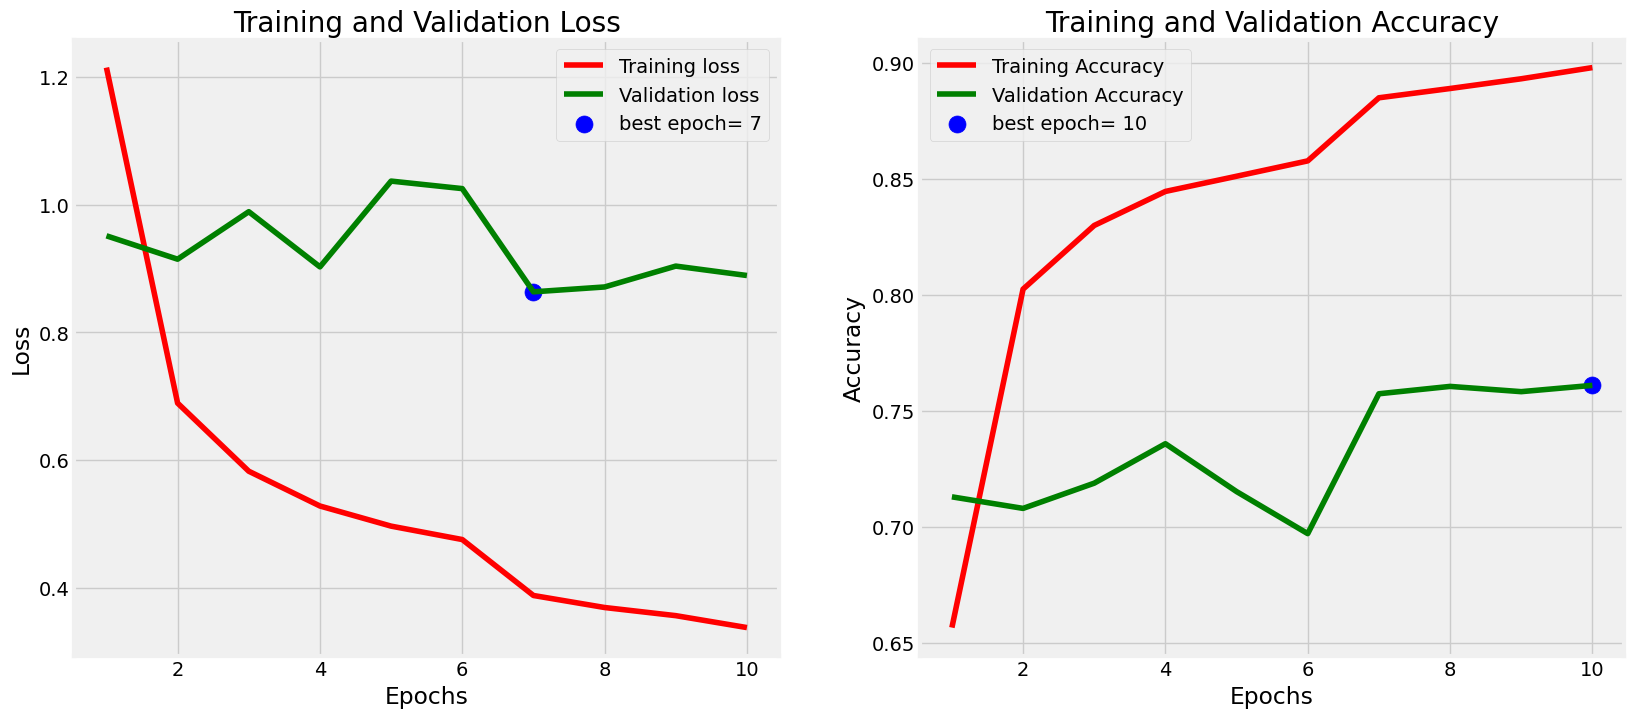

In [5]:
# train variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# history plots
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [9]:
#unfreeze all layers except batchnorm
base_model.trainable = True
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
#####################################################################
model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'])

print(model.summary())
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    epochs=5,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [15]:
################################################################################################################################################
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    epochs=5,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model.save_weights('./checkpoints/my_checkpoint')
################################################################################################################################################

Epoch 1/5
1360/1360 [==============================] - 4923s 4s/step - loss: 0.0211 - accuracy: 0.9951 - val_loss: 0.1527 - val_accuracy: 0.9533 - lr: 1.0000e-05
Epoch 2/5
1360/1360 [==============================] - 4697s 3s/step - loss: 0.0162 - accuracy: 0.9963 - val_loss: 0.1627 - val_accuracy: 0.9463 - lr: 1.0000e-05
Epoch 3/5
1360/1360 [==============================] - 4694s 3s/step - loss: 0.0128 - accuracy: 0.9973 - val_loss: 0.1687 - val_accuracy: 0.9503 - lr: 1.0000e-05
Epoch 4/5
1360/1360 [==============================] - 4694s 3s/step - loss: 0.0053 - accuracy: 0.9993 - val_loss: 0.1022 - val_accuracy: 0.9694 - lr: 2.0000e-06
Epoch 5/5
1360/1360 [==============================] - 4693s 3s/step - loss: 0.0035 - accuracy: 0.9998 - val_loss: 0.0990 - val_accuracy: 0.9714 - lr: 2.0000e-06


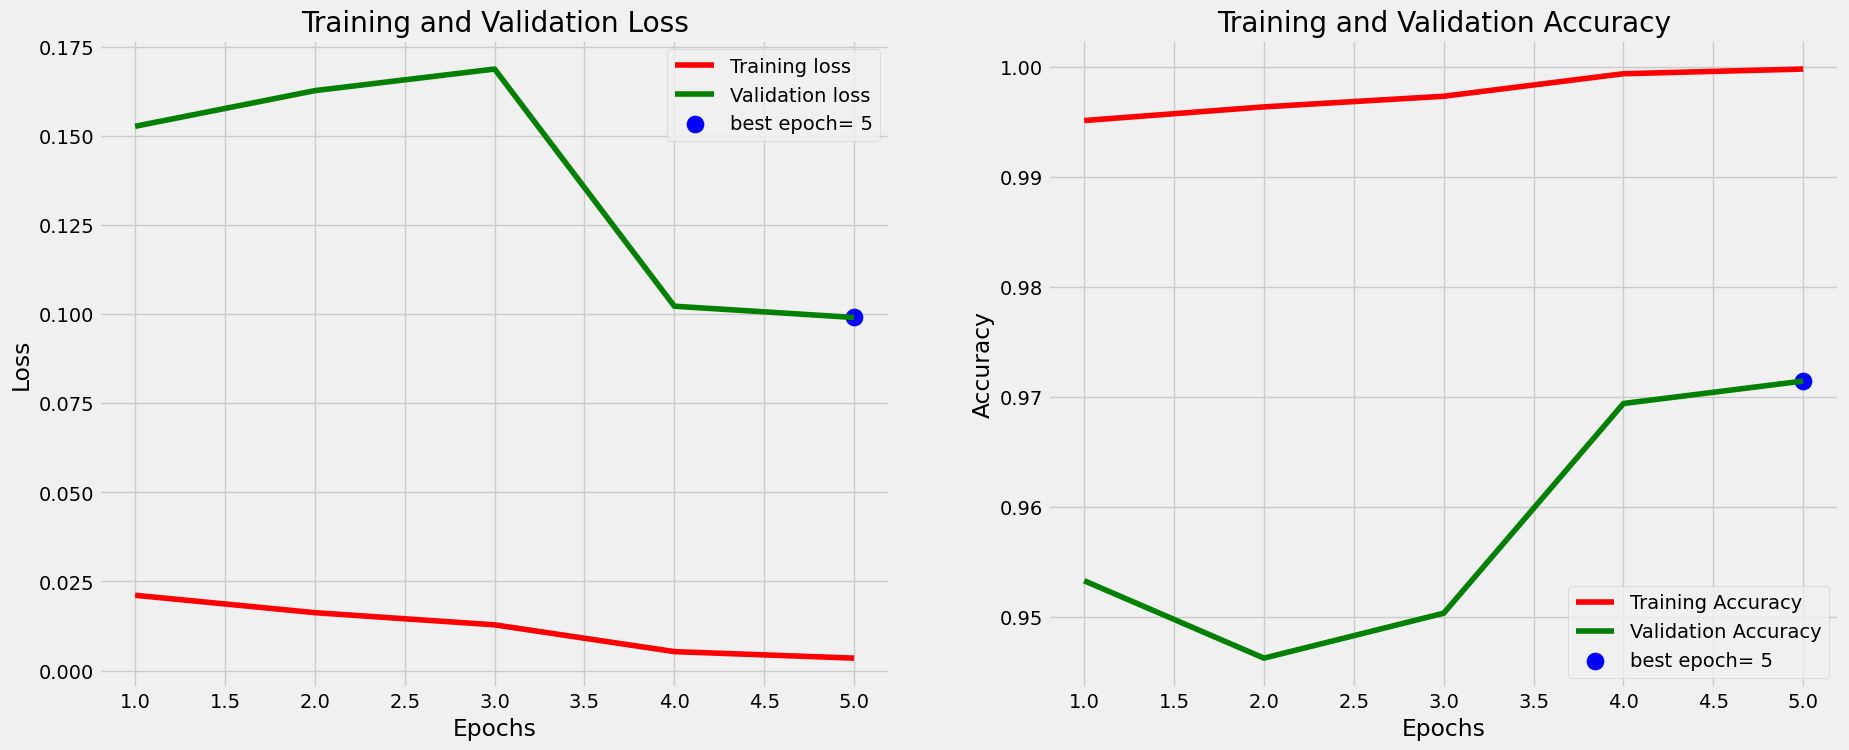

In [16]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [17]:
results = model.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.16908
Test Accuracy: 95.22%


In [18]:
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

198/198 [==============================] - 190s 958ms/step
F1 Score: 0.919360597734913
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.97      0.96      0.97       720
          10       0.99      0.99      0.99       660
          11       0.86      0.95      0.90       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.99      0.99      0.99       210
          16       0.99      0.96      0.97       150
          17       1.00      1.00      1.00       360
          18       1.00      0.93      0.96       390
          19       0.62      0.95      0.75        60
           2       0.90      0.98      0.94       750
          20       0.70      0.69      0.70        90
          21       0.98      0.54      0.70        90
          22       0.99      0.80      0.88     

In [19]:
# Save trained model
model.save('tl_mnv2.h5')

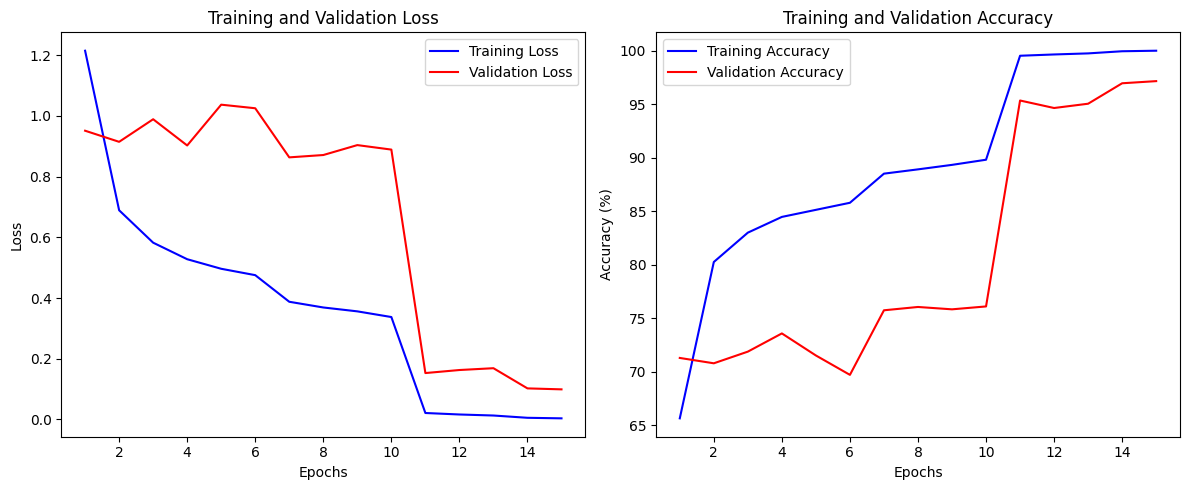

In [2]:
import matplotlib.pyplot as plt
#PLOT OF ALL TRAINING
epochs_1 = range(1, 11)
training_loss_1 = [1.2148, 0.6891, 0.5823, 0.5278, 0.4963, 0.4753, 0.3876, 0.3688, 0.3560, 0.3373]
training_accuracy_1 = [65.65, 80.25, 82.99, 84.46, 85.12, 85.78, 88.50, 88.90, 89.32, 89.80]
validation_loss_1 = [0.9512, 0.9146, 0.9890, 0.9026, 1.0370, 1.0252, 0.8634, 0.8711, 0.9038, 0.8890]
validation_accuracy_1 = [71.29, 70.79, 71.88, 73.58, 71.52, 69.71, 75.74, 76.05, 75.83, 76.10]

# Data for second set of epochs
epochs_2 = range(11, 16)  # Adjusted x-axis values
training_loss_2 = [0.0211, 0.0162, 0.0128, 0.0053, 0.0035]
training_accuracy_2 = [99.51, 99.63, 99.73, 99.93, 99.98]
validation_loss_2 = [0.1527, 0.1627, 0.1687, 0.1022, 0.0990]
validation_accuracy_2 = [95.33, 94.63, 95.03, 96.94, 97.14]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(list(epochs_1) + list(epochs_2), training_loss_1 + training_loss_2, 'b', label='Training Loss')
plt.plot(list(epochs_1) + list(epochs_2), validation_loss_1 + validation_loss_2, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(list(epochs_1) + list(epochs_2), training_accuracy_1 + training_accuracy_2, 'b', label='Training Accuracy')
plt.plot(list(epochs_1) + list(epochs_2), validation_accuracy_1 + validation_accuracy_2, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Found 12630 images belonging to 43 classes.
198/198 [==============================] - 204s 1s/step


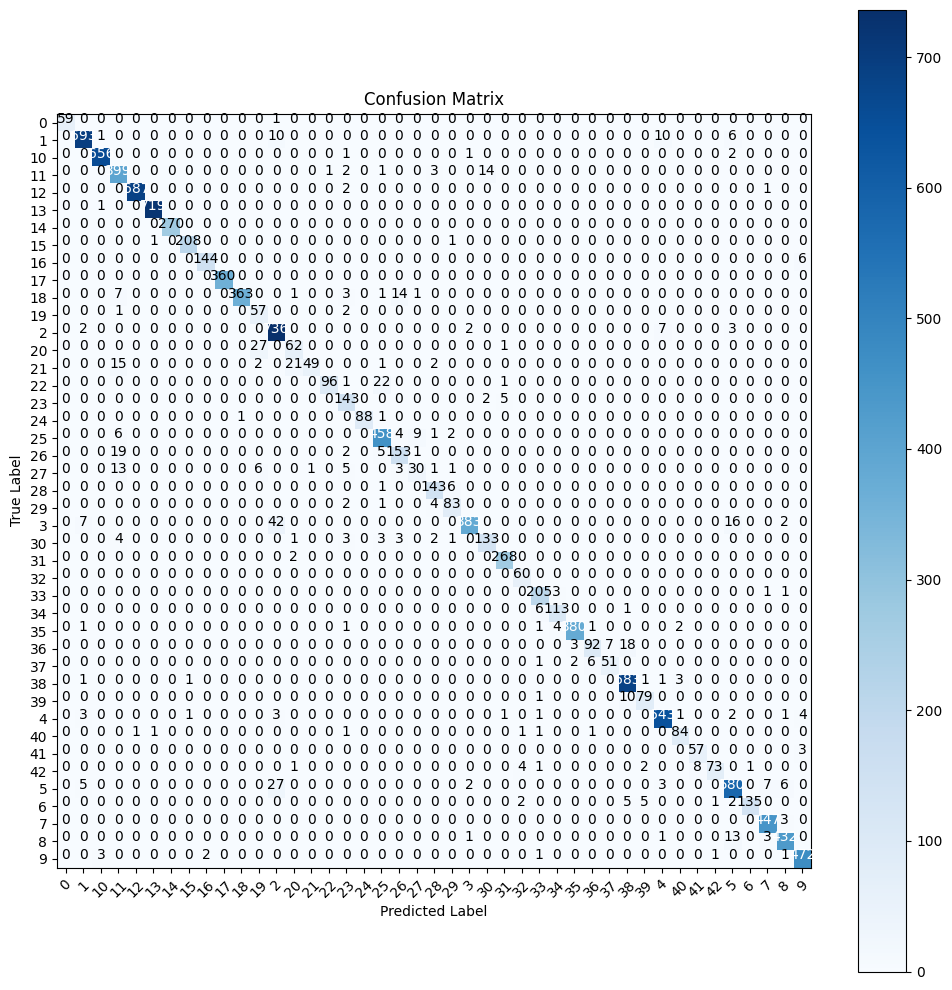

In [7]:
#CONFUSION

import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, History
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

test_dir = "F:\DATASET\TRAFFIC SIGNS PICKLE DATA 0 224x224/test"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
# Load saved model
model = tf.keras.models.load_model('tl_mnv2.h5')
predictions = model.predict(test_generator)
true_labels = test_generator.classes
conf_matrix = confusion_matrix(true_labels, np.argmax(predictions, axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = len(test_generator.class_indices)
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, test_generator.class_indices, rotation=45)
plt.yticks(tick_marks, test_generator.class_indices)

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment='center', color='white' if conf_matrix[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()